In [2]:
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
bucket="weteh-data-repo-us-east-2"
photo="airbus-object-detection/train_v2/000155de5.jpg"
# model='arn:aws:rekognition:us-east-2:869530972998:project/airbus_object_detection/version/airbus_object_detection.2020-05-27T14.37.30/1590608250659'
model="arn:aws:rekognition:us-east-2:869530972998:project/airbus_object_detection/version/airbus_object_detection.2020-05-27T15.03.19/1590609799145"
min_confidence=50

rekognition=boto3.client('rekognition')
s3 = boto3.client("s3")

/home/ubuntu/anaconda3/envs/tf_2.x/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Image')

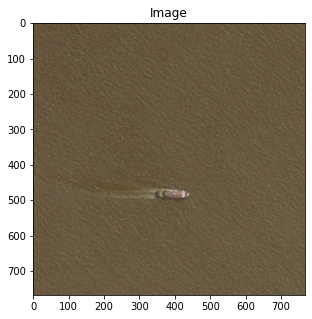

In [4]:
file_obj = s3.get_object(Bucket=bucket, Key=photo)
file_content = file_obj["Body"].read()
np_array = np.fromstring(file_content, np.uint8)
image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)    
fig, (ax1) = plt.subplots(1, 1, figsize = (5, 5))
ax1.imshow(image_np)
ax1.set_title('Image')

In [7]:
min_confidence=80
response = rekognition.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
MinConfidence=min_confidence,
ProjectVersionArn=model)

In [8]:
ship_dir = "/mnt/deep_learning"
test_images_dir = "{}/test_v2".format(ship_dir)


/home/ubuntu/anaconda3/envs/tf_2.x/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


Label boat
Confidence 99.96700286865234


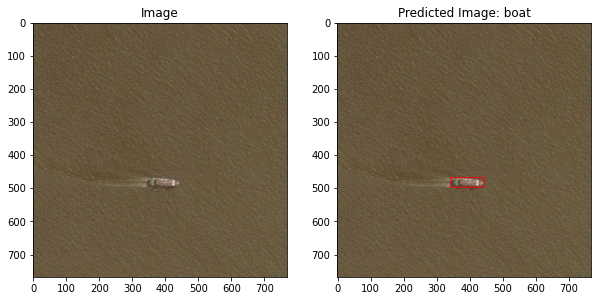

In [9]:
file_obj = s3.get_object(Bucket=bucket, Key=photo)
file_content = file_obj["Body"].read()
np_array = np.fromstring(file_content, np.uint8)
image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(image_np)
ax1.set_title('Image')

customLabel = response['CustomLabels'][0]
imgWidth = 768
imgHeight = 768
print('Label ' + str(customLabel['Name'])) 
print('Confidence ' + str(customLabel['Confidence'])) 
if 'Geometry' in customLabel:
    box = customLabel['Geometry']['BoundingBox']
    left = int(imgWidth * box['Left'])
    top = int(imgHeight * box['Top'])
    width = int(imgWidth * box['Width'])
    height = int(imgHeight * box['Height'])
    img_1 = image_np.copy()
    cv2.rectangle(img_1, (left, top), (width + left, top + height), (255, 0, 0), 2)
#     fig, (ax2) = plt.subplots(1, 1, figsize = (5, 5))
    ax2.imshow(img_1)
    ax2.set_title('Predicted Image: {}'.format(customLabel['Name']))

In [10]:
import os
import random
test_images = os.listdir(test_images_dir)

/home/ubuntu/anaconda3/envs/tf_2.x/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


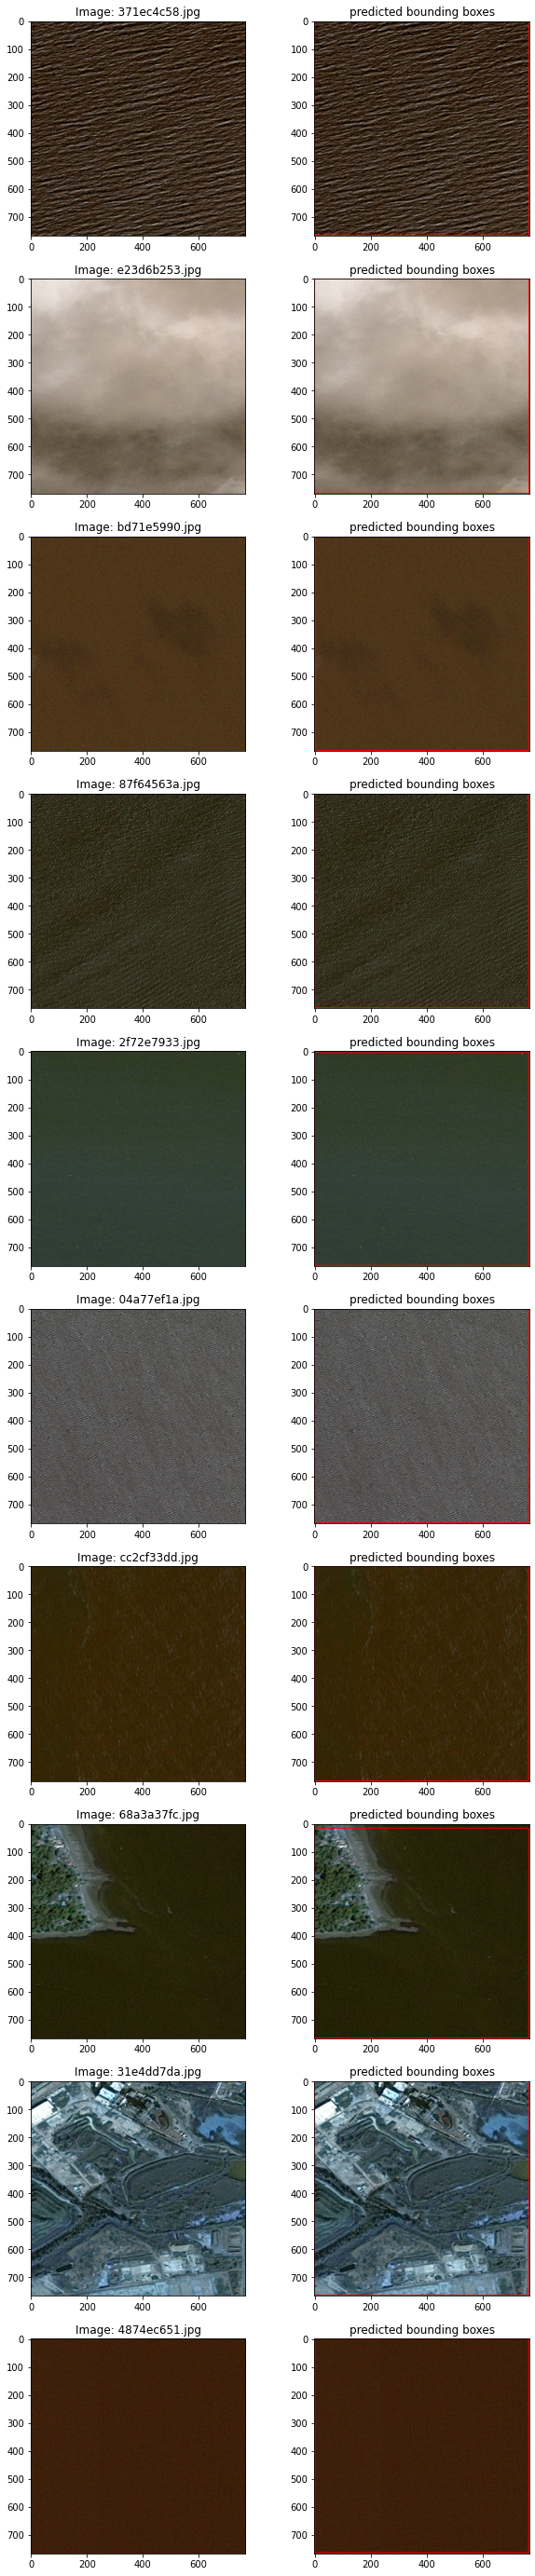

In [11]:
# random.seed(20)
imgWidth = 768
imgHeight = 768
min_confidence=90
test_sample_size = 10
idx = 0
# fig, ax = plt.subplots(test_sample_size, 1, figsize = (5, 5 * test_sample_size))
fig, m_axs = plt.subplots(test_sample_size, 2, figsize = (10, 5*test_sample_size))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_images[0:test_sample_size]):
# for i in range(test_sample_size):
    value = random.randint(0, len(test_images)-1)
    base_img_name = test_images[value]
    s3_photo_path ="airbus-object-detection/test_v2/{}".format(base_img_name)
    file_obj = s3.get_object(Bucket=bucket, Key=s3_photo_path)
    file_content = file_obj["Body"].read()
    np_array = np.fromstring(file_content, np.uint8)
    image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)    
    ax1.imshow(image_np)
    ax1.set_title('Image: {}'.format(base_img_name))
    response = rekognition.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': s3_photo_path}},
    MinConfidence=min_confidence,
    ProjectVersionArn=model)
    img_1 = image_np.copy()
    ax2.set_title('predicted bounding boxes')
#     print(response)
    if response['CustomLabels']:
        for customLabel in response['CustomLabels']:
#         customLabel = response['CustomLabels'][0]
            if 'Geometry' in customLabel:
                box = customLabel['Geometry']['BoundingBox']
                left = int(imgWidth * box['Left'])
                top = int(imgHeight * box['Top'])
                width = int(imgWidth * box['Width'])
                height = int(imgHeight * box['Height'])
                cv2.rectangle(img_1, (left, top), (width + left, top + height), (255, 0, 0), 2)
    ax2.imshow(img_1)
    
    

In [12]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [13]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [14]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))

In [15]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)

In [17]:
import os
import random
from skimage.measure import label, regionprops
train_image_dir = "{}/train_v2".format(ship_dir)
validation_images = os.listdir(train_image_dir)

/home/ubuntu/anaconda3/envs/tf_2.x/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


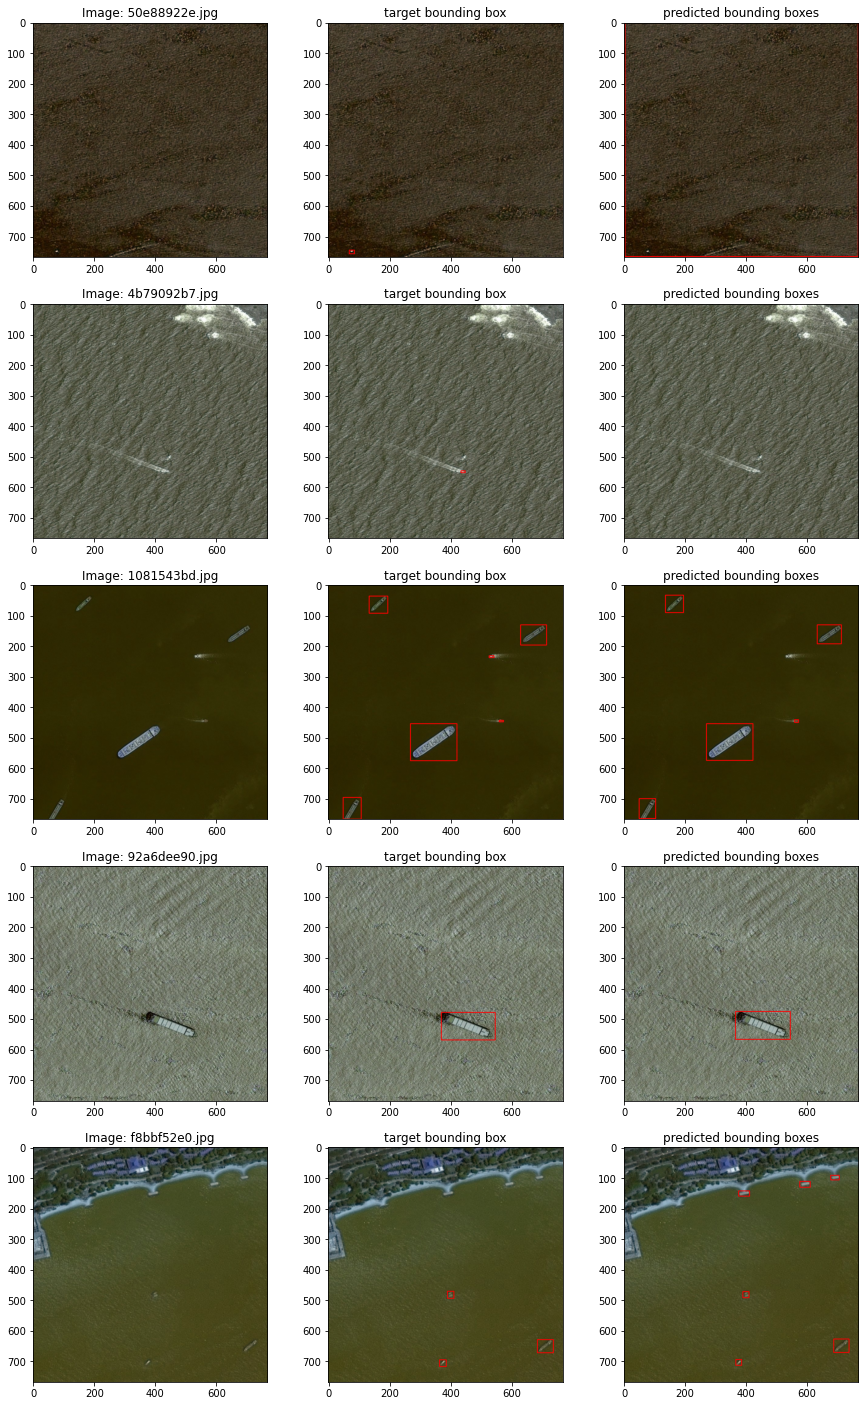

In [18]:
imgWidth = 768
imgHeight = 768
min_confidence=90
validation_sample_size = 5
fig, m_axs = plt.subplots(validation_sample_size, 3, figsize = (15, 5*validation_sample_size))
# fig, m_axs = plt.subplots(validation_sample_size, 2, figsize = (15, 5*validation_sample_size))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), c_img_name in zip(m_axs, validation_images[0:validation_sample_size]):
# for i in range(test_sample_size):
    value = random.randint(0, len(images_with_ship)-1)
    base_img_name = images_with_ship[value]
    s3_photo_path ="airbus-object-detection/train_v2/{}".format(base_img_name)
    file_obj = s3.get_object(Bucket=bucket, Key=s3_photo_path)
    file_content = file_obj["Body"].read()
    np_array = np.fromstring(file_content, np.uint8)
    image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)    
    ax1.imshow(image_np)
    ax1.set_title('Image: {}'.format(base_img_name))    
    
    rle_0 = masks.query('ImageId=="'+base_img_name+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = image_np.copy()
    for prop in props:
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[4], prop.bbox[3]), (255, 0, 0), 2)

    ax2.set_title("target bounding box")
    ax2.imshow(img_1)

    response = rekognition.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': s3_photo_path}},
    MinConfidence=min_confidence,
    ProjectVersionArn=model)
    img_2 = image_np.copy()
    ax3.set_title('predicted bounding boxes')
    if response['CustomLabels']:
        for customLabel in response['CustomLabels']:
            if 'Geometry' in customLabel:
                box = customLabel['Geometry']['BoundingBox']
                left = int(imgWidth * box['Left'])
                top = int(imgHeight * box['Top'])
                width = int(imgWidth * box['Width'])
                height = int(imgHeight * box['Height'])
                cv2.rectangle(img_2, (left, top), (width + left, top + height), (255, 0, 0), 2)
    ax3.imshow(img_2)    